In [1]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline 
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact,pdp_interact_plot
import eli5
from eli5.sklearn import PermutationImportance
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
from joblib import dump
from joblib import load
%config IPCompleter.greedy=True
# size for web display
plt.rcParams['figure.dpi'] = 72

In [2]:
df1 = pd.read_csv('https://raw.githubusercontent.com/JonNData/used-car-predictor/master/notebooks/vehicles_trimmed1.csv')
df1

,Unnamed: 0,id,region,price,year,manufacturer,model,condition,cylinders,fuel,...,transmission,drive,size,type,paint_color,image_url,county,state,lat,long
0,0,7034441763,salt lake city,17899.0,2012.0,volkswagen,golf r,excellent,4 cylinders,gas,...,manual,4wd,compact,hatchback,black,https://images.craigslist.org/00G0G_fTLDWM5Xyv...,NaN,ut,40.7372,-111.858
1,1,7034440610,salt lake city,NaN,2016.0,ford,f-150,excellent,NaN,gas,...,automatic,4wd,NaN,NaN,NaN,https://images.craigslist.org/00v0v_7Cu0buIofU...,NaN,ut,40.5881,-111.884
2,2,7034440588,salt lake city,46463.0,2015.0,gmc,sierra 1500,excellent,NaN,gas,...,automatic,4wd,NaN,NaN,white,https://images.craigslist.org/01515_lPvJ9bfbdY...,NaN,ut,40.5881,-111.884
3,3,7034440546,salt lake city,NaN,2016.0,ford,f-150,excellent,NaN,gas,...,automatic,4wd,NaN,NaN,NaN,https://images.craigslist.org/00T0T_6Rjfp3NS4O...,NaN,ut,40.5881,-111.884
4,4,7034406932,salt lake city,49999.0,2018.0,ford,f-450,NaN,NaN,diesel,...,automatic,4wd,NaN,pickup,white,https://images.craigslist.org/00W0W_8yIUwRBXXd...,NaN,ut,40.3744,-104.694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509572,509572,7034554007,salt lake city,15476.0,2012.0,nissan,xterra,NaN,6 cylinders,gas,...,automatic,4wd,NaN,SUV,NaN,https://images.craigslist.org/00z0z_3ERBmVoD5s...,NaN,ut,39.6405,-104.961
509573,509573,7034538385,salt lake city,9881.0,2008.0,bmw,3 series 328i,NaN,6 cylinders,gas,...,automatic,rwd,NaN,convertible,NaN,https://images.craigslist.org/01313_38rMiNAW18...,NaN,ut,39.6405,-104.961
509574,509574,7034523643,salt lake city,24895.0,2019.0,jeep,cherokee,NaN,4 cylinders,gas,...,automatic,4wd,NaN,SUV,white,https://images.craigslist.org/00606_dOtGS5RmTi...,NaN,ut,45.1637,-113.894
509575,509575,7034458858,salt lake city,32500.0,2017.0,NaN,Porsche Macan GTS,excellent,6 cylinders,gas,...,automatic,NaN,NaN,NaN,red,https://images.craigslist.org/00s0s_32yAwr0KMt...,NaN,ut,41.3112,-111.969


Why & how were target, metric, and baseline chosen?How was leakage avoided. When & why is the model (or not) useful?


Price was chosen as a natural target because it is information that would be most applicable to the user. Whether someone is looking to sell or buy a car, price is the bottom line.

Columns did not contain leakage because the price of the post was declared at the time of making the post. The features included are not related to a sale price.

Started with a baseline of 8613.48 MAE of a mean baseline or a 7829.12 MAE of the simplest linear regression based on ‘year’. Quickly beat these scores with a decision tree. For metrics, I chose R^2 for variance explainability and MAE for simple error comparison.

Limitations: The model is mostly useful for a quick price estimation on used cars. Getting a specific model or sale price can be done on the larger original used cars dataset.


In [3]:
# Choose target
target = 'price'

In [4]:
# Is your problem regression or classification?
# Regression, predicting a continuous variable with many levels

Text(0.5, 1.0, 'Price Distribution')

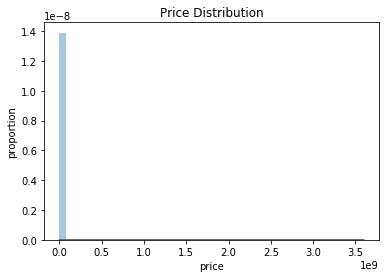

In [5]:
# Target distribution
fig, ax = plt.subplots()
sns.distplot(df1['price'])
ax.set_ylabel('proportion')
ax.set_title('Price Distribution')

In [6]:
pd.options.display.float_format = '{:.1f}'.format

In [7]:
print(np.median(df1['price']))
y = df1['price']
y.describe()
# Very right skewed but the 0s are holding it back even more. 
# Let's look at logs

nan


count       465998.0
mean         59921.3
std       10012722.5
min              1.0
25%           5000.0
50%          10500.0
75%          18950.0
max     3600028900.0
Name: price, dtype: float64

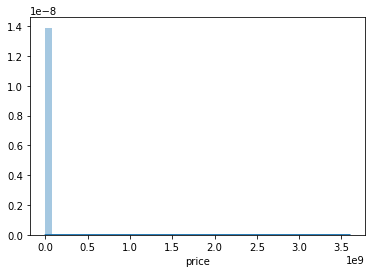

In [8]:
y = y.replace(0, np.NaN)
sns.distplot(y)

In [9]:
# It was deemed not worth log transforming, I did some modeling below and R^2 was worse
# y_log = np.log1p(y)
# sns.distplot(y_log)

In [10]:
# Chop out some outliers

df2 = df1
df2['price'] = df2['price'].replace(0,np.NaN)
df2 = df2.dropna(subset=['price'])
df2 = df2[(df2['price'] >= np.percentile(df2['price'], 0.05)) &
          (df2['price'] <= np.percentile(df2['price'], 99.95))]
df2['price'].describe()

count   465765.0
mean     13606.2
std      11430.8
min          1.0
25%       5000.0
50%      10500.0
75%      18949.0
max     149000.0
Name: price, dtype: float64

Text(0.5, 1.0, 'Price Distribution')

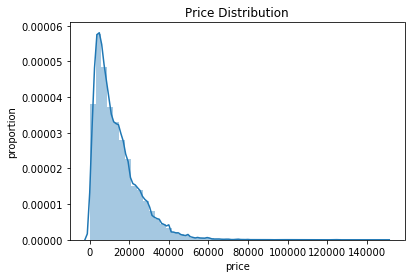

In [11]:
fig, ax = plt.subplots()
sns.distplot(df2['price'])
ax.set_ylabel('proportion')
ax.set_title('Price Distribution')

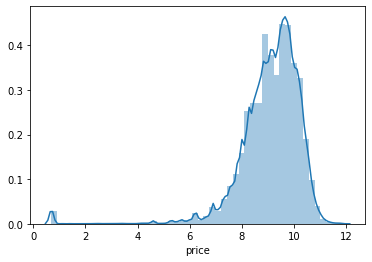

In [12]:
y = np.log1p(df2['price'])
sns.distplot(y)
# Now it's left skewed. Perhaps not worth log transform

In [13]:
y.describe()

count   465765.0
mean         9.1
std          1.2
min          0.7
25%          8.5
50%          9.3
75%          9.8
max         11.9
Name: price, dtype: float64

In [14]:
# Dollar amount of the average
np.e**9.1

8955.292703482504

In [15]:
# Choose your evaluation metric(s).

#  I chose R^2 for variance explainability and MAE for simple error comparison.

In [16]:
#Choose which observations you will use to train, validate, and test your model.
train_orig, test = train_test_split(df2.drop(columns=['county','Unnamed: 0']) , test_size = 0.1, train_size = 0.9)
test

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,image_url,state,lat,long
344943,7041536673,lincoln,2800.0,2005.0,lincoln,navigator,NaN,NaN,gas,nan,clean,automatic,NaN,NaN,NaN,NaN,https://images.craigslist.org/00k0k_lg3IIXqHvt...,ne,40.8,-96.7
491444,7044615510,el paso,4995.0,2004.0,honda,pilot,good,6 cylinders,gas,230123.0,clean,automatic,NaN,NaN,SUV,silver,https://images.craigslist.org/00808_990qEgCycK...,tx,31.8,-106.4
256311,7045252753,new orleans,10500.0,2012.0,lexus,es350,good,6 cylinders,gas,45747.0,rebuilt,automatic,NaN,NaN,NaN,grey,https://images.craigslist.org/00U0U_hUwPo5ZF3x...,la,30.0,-89.9
295314,7034872563,saginaw-midland-baycity,14300.0,2014.0,toyota,prius,like new,4 cylinders,hybrid,56182.0,clean,automatic,fwd,mid-size,hatchback,silver,https://images.craigslist.org/00y0y_gBpPNbYdgG...,mi,43.6,-84.2
380021,7049689253,rochester,1450.0,2007.0,saturn,vue,good,6 cylinders,gas,151946.0,clean,automatic,fwd,NaN,NaN,NaN,https://images.craigslist.org/01313_frkRogI7J7...,ny,43.2,-77.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390935,7045709663,akron / canton,2950.0,2005.0,gmc,envoy 4x4,NaN,6 cylinders,gas,106000.0,clean,automatic,4wd,NaN,SUV,NaN,https://images.craigslist.org/00i0i_4RN3BuPGI4...,oh,41.1,-81.2
372453,7040028090,hudson valley,15600.0,2016.0,subaru,legacy,NaN,4 cylinders,gas,22558.0,clean,automatic,4wd,NaN,sedan,NaN,https://images.craigslist.org/00d0d_ivvK7VOqec...,ny,41.6,-73.1
121288,7049704134,SF bay area,83994.0,2017.0,NaN,Porsche 911,excellent,6 cylinders,gas,12612.0,clean,automatic,rwd,sub-compact,convertible,blue,https://images.craigslist.org/00Y0Y_19jqs5kwVZ...,ca,37.4,-122.1
367759,7045885741,buffalo,18948.0,2016.0,hyundai,santa fe,NaN,6 cylinders,gas,48058.0,clean,automatic,4wd,compact,SUV,grey,https://images.craigslist.org/00K0K_1H5dFP2PNh...,ny,42.8,-78.8


In [17]:
train, val = train_test_split(train_orig, train_size = 0.9, test_size = 0.1)
train

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,image_url,state,lat,long
163659,7045181470,jacksonville,1.0,2015.0,audi,s4,excellent,6 cylinders,gas,58606.0,clean,automatic,4wd,compact,sedan,blue,https://images.craigslist.org/00n0n_htalgKOI22...,fl,28.5,-81.4
99214,7049425716,orange county,4600.0,2008.0,saturn,outlook,NaN,NaN,gas,158048.0,clean,automatic,fwd,NaN,SUV,red,https://images.craigslist.org/00B0B_gEV7MyzCrO...,ca,33.5,-117.7
17168,7047196337,bellingham,32500.0,2016.0,gmc,sierra 1500,NaN,8 cylinders,gas,64283.0,clean,automatic,4wd,NaN,truck,NaN,https://images.craigslist.org/01515_5Wa5xyn6Nn...,wa,48.8,-122.5
243024,7047380054,"kansas city, MO",7995.0,2007.0,chevrolet,suburban 1500,NaN,8 cylinders,other,229220.0,clean,automatic,4wd,NaN,SUV,custom,https://images.craigslist.org/00Q0Q_gJQbgddNEC...,ks,38.6,-94.3
350397,7047793798,central NJ,19500.0,1968.0,NaN,oldsmobile cutlass,NaN,8 cylinders,gas,nan,clean,automatic,rwd,mid-size,coupe,silver,https://images.craigslist.org/00s0s_6FWx3fNQwd...,nj,40.5,-74.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139059,7046271038,fort collins / north CO,27000.0,2014.0,jeep,grand cherokee,NaN,8 cylinders,gas,56906.0,clean,automatic,4wd,NaN,SUV,NaN,https://images.craigslist.org/00i0i_9eX4tkGy4T...,co,39.6,-105.0
106104,7038087478,redding,8914.0,2014.0,dodge,dart gt,excellent,4 cylinders,gas,153275.0,clean,manual,fwd,NaN,sedan,white,https://images.craigslist.org/00P0P_eTzrpuYCKF...,ca,40.5,-122.3
313559,7047449677,springfield,29998.0,2018.0,chevrolet,silverado 1500,excellent,8 cylinders,gas,31000.0,clean,automatic,4wd,NaN,truck,black,https://images.craigslist.org/00E0E_ag6Ji5DhKK...,mo,36.7,-91.8
300873,7036487274,fargo / moorhead,26490.0,2017.0,jeep,grand cherokee limited,like new,6 cylinders,gas,43926.0,clean,automatic,rwd,full-size,SUV,black,https://images.craigslist.org/00606_j82oRMZCWK...,mn,47.9,-97.0


In [18]:
# MEAN BASELINE
#  For the evaluation metric you chose, what score would you get just by guessing?
# R^2 for a flat line of the mean would be 0. Let's look at the MAE
list_of_mean = [train['price'].mean()] * len(val['price'])
mean_absolute_error(val['price'], list_of_mean)

8618.535989332982

In [19]:
# LINEAR REGRESSION (to beat) BASELINE
# Let's do a univariate linear regression as a baseline as well
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(train[['year']])
lr = LinearRegression()
model = lr.fit(imp_mean.transform(train[['year']]),train['price'])

print('MAE:', mean_absolute_error(val['price'], model.predict(imp_mean.transform(val[['year']]))))
print('R^2:', r2_score(val['price'], model.predict(imp_mean.transform(val[['year']]))))
# Alrighty then. Got some baselines!

MAE: 7820.209774912651
R^2: 0.10791712315490853


In [20]:
target = 'price'
features = ['region', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'state', 'lat',
       'long']
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [21]:
# Heck let's do a decision tree as a baseline too
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    DecisionTreeRegressor(max_depth=10)
)
pipeline.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['region', 'manufacturer', 'model',
                                      'condition', 'cylinders', 'fuel',
                                      'title_status', 'transmission', 'drive',
                                      'size', 'type', 'paint_color', 'state'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'region',
                                          'data_type': dtype('O'),
                                          'mapping': jacksonville              1
orange c...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                       max_depth=10, max_fea

In [22]:
y_pred = pipeline.predict(X_val)
print('MAE:', mean_absolute_error(y_val, y_pred))
print('R^2:', r2_score(y_val, y_pred))

# Pretty dope tree

MAE: 4037.7797008017756
R^2: 0.6651729638949174


In [23]:
# Explore more
train.dtypes

id                int64
region           object
price           float64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
drive            object
size             object
type             object
paint_color      object
image_url        object
state            object
lat             float64
long            float64
dtype: object

Text(0.5, 1.0, 'price by year')

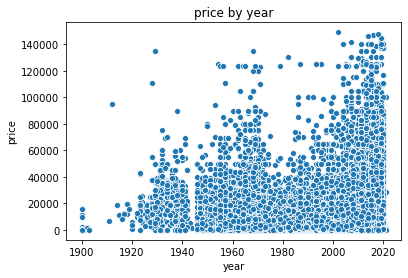

In [24]:
sns.scatterplot(train['year'], train['price'])
plt.title('price by year')

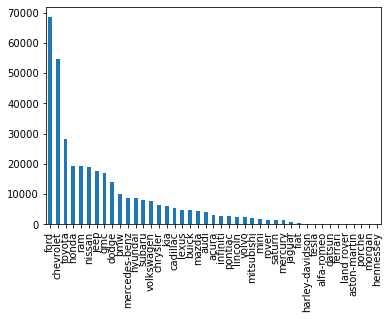

In [25]:
train['manufacturer'].value_counts().plot(kind='bar')

Text(0.5, 1.0, 'price by color')

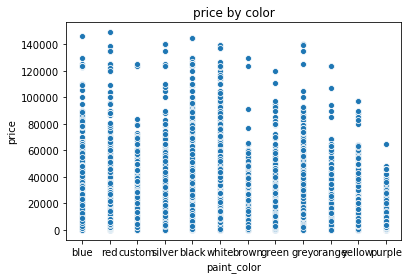

In [26]:
sns.scatterplot(train['paint_color'], train['price'])
plt.title('price by color')

In [27]:
# BEAT BASELINE WITH TREES
%time
# Random Forest model

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestRegressor(n_estimators=50)
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)
print('MAE:', mean_absolute_error(y_val, y_pred))
print('R^2:', r2_score(y_val, y_pred))

# lit, already happy about that

Wall time: 0 ns
MAE: 2212.9079436941706
R^2: 0.8390164797854873


In [28]:
# Earlier models that needed extra tuning
# XGBoost

# pipeline = make_pipeline(
#     ce.OrdinalEncoder(), 
#     # SimpleImputer(strategy='median'),  missing values accepted in this
#     XGBRegressor(n_estimators=70, random_state=42, n_jobs=-1)
# )
# pipeline.fit(X_train, y_train)

# y_pred = pipeline.predict(X_val)
# print('MAE:', mean_absolute_error(y_val, y_pred))
# print('R^2:', r2_score(y_val, y_pred))

# Much to tune

In [29]:
# Early stopping, 
# encoder = ce.OrdinalEncoder()
# X_train_encoded = encoder.fit_transform(X_train)
# X_val_encoded = encoder.transform(X_val)
# model = XGBRegressor(
#     n_estimators= 500, # up to 1000, depends on early stop
#     max_depth = 7,
#     learning_rate= 0.5, # try higher learning rate
# )

# eval_set = [(X_train_encoded, y_train), (X_val_encoded, y_val)]

# model.fit(X_train_encoded,y_train,
#           eval_set = eval_set,
#           eval_metric = 'mae',
#           early_stopping_rounds = 50)
# Random forest still better, will have to play with it

In [30]:
# Early stopping, TUNED
%time
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
model = XGBRegressor(
    n_estimators= 100, # up to 100, depends on early stop
    max_depth = 35,
    learning_rate= 0.10, # Lower rate helps with overfitting.
    n_jobs=-3
)

eval_set = [(X_train_encoded, y_train), (X_val_encoded, y_val)]

model.fit(X_train_encoded,y_train,
          eval_set = eval_set, # This is what is being scored (why we have two col)
          eval_metric = 'mae',
          early_stopping_rounds = 2) #stop if score not improved in n rounds
    

Wall time: 0 ns
[14:12:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:12291.9	validation_1-mae:12303.3
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 2 rounds.
[1]	validation_0-mae:11115.2	validation_1-mae:11153.9
[2]	validation_0-mae:10056	validation_1-mae:10126.2
[3]	validation_0-mae:9101.54	validation_1-mae:9210.38
[4]	validation_0-mae:8241.27	validation_1-mae:8389.35
[5]	validation_0-mae:7465.21	validation_1-mae:7653.97
[6]	validation_0-mae:6764.87	validation_1-mae:7003.53
[7]	validation_0-mae:6134.88	validation_1-mae:6426.61
[8]	validation_0-mae:5565.34	validation_1-mae:5911.31
[9]	validation_0-mae:5052.28	validation_1-mae:5454.05
[10]	validation_0-mae:4588.06	validation_1-mae:5049.35
[11]	validation_0-mae:4169.25	validation_1-mae:4692.45
[12]	validation_0-mae:3790.86	validation_1-mae:4378.95
[13]	vali

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=35, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-3, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Text(0.5, 1.0, 'XGBoost MAE by Round')

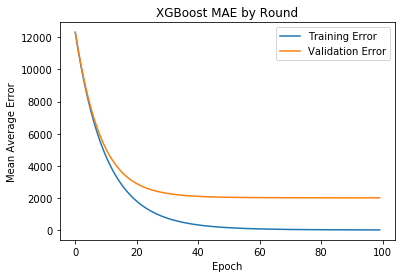

In [31]:
# Let's plot XGBoost's journey

results = model.evals_result_
training_err = results['validation_0']['mae']
validation_err = results['validation_1']['mae']
epoch = list(range(0,len(training_err)))

plt.plot(epoch,training_err, label = 'Training Error')
plt.plot(epoch,validation_err, label = 'Validation Error')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean Average Error')
plt.title('XGBoost MAE by Round')

In [ ]:
# Can we just take the output model and use that??
%time
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=35, min_child_weight=1, missing=None, n_estimators=350,
             n_jobs=-3, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
model.fit(X_train_encoded, y_train)

Wall time: 0 ns
[14:15:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# XGBoost R^2
y_pred = model.predict(X_val_encoded)
print('R^2:', r2_score(y_val, y_pred))

# BEAT BASELINE, slightly better than RF R^2= 0.8407 (scores vary with iteration)

In [ ]:
# Clean up for permutation importances/ pdp

imputer = SimpleImputer(strategy='median')
X_val_imputed = imputer.fit_transform(X_val_encoded)
#df_val_imputed = pd.DataFrame(data= val_imputed, columns=val.columns)
# X_val_imputed = df_val_imputed[features]


xgb = model.fit(X_val_imputed, y_val)

In [ ]:
# Permutation importances
permuter = PermutationImportance(
    model,
    scoring= 'r2',
    n_iter = 5,
    random_state=42

)

permuter.fit(X_val_imputed, y_val)

In [ ]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

# Here I can consider cutting down columns, would it make a better app?
# predictively I'm ok, not great, so should I prioritize user experience

In [ ]:
eli5.show_weights(
    permuter,
    top=11, # number of features to show, no limit
    feature_names= feature_names, # must be a list
)

In [ ]:
# x Make at least 1 partial dependence plot to explain your model.

val_imp_df = pd.DataFrame(X_val_imputed, columns = X_val.columns)
feature = 'year'

isolated = pdp_isolate(
    model = pipeline,
    dataset= val_imp_df,
    model_features= X_val.columns,
    feature = feature
)
pdp_plot(isolated, feature_name= feature)

# neat. You can kinda see what cars people put up for sale have value.

In [ ]:
# let's look at that old year
val.sort_values(by='year').head(4)

In [ ]:
# STRETCH
#  Make multiple PDPs with 2 features in interaction.

feature= ['year', 'odometer']

interaction = pdp_interact(
    model = pipeline,
    dataset = val_imp_df,
    model_features= X_val.columns,
    features= feature
)
pdp_interact_plot(interaction, plot_type='grid', feature_names=feature)
# Kinda meaningless without the drive dictionary

In [ ]:
#  Make at least 1 Shapley force plot to explain an individual prediction.

row = X_val_encoded.iloc[5]
y_val.iloc[[5]], model.predict(row)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value= explainer.expected_value,
    shap_values = shap_values,
    features= row

)


In [ ]:
## Final model for app usage

target = 'price'
features1 = ['year', 'manufacturer', 'cylinders','fuel', 'odometer', 'drive']
X_train1 = train[features1]
y_train = train[target]
X_val1 = val[features1]
y_val = val[target]
X_test1 = test[features1]
y_test = test[target]

In [ ]:
# pipeline1 = make_pipeline(
#     ce.TargetEncoder(),
#     SimpleImputer(strategy='median'),
#     RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
#                                        criterion='mae', max_depth=18,
#                                        max_features='auto', max_leaf_nodes=None,
#                                        max_samples=None,
#                                        min_impurity_decrease=0.0,
#                                        min_impurity_split=None,
#                                        min_samples_leaf=1, min_samples_split=2,
#                                        min_weight_fraction_leaf=0.0,
#                                        n_estimators=35, n_jobs=None,
#                                        oob_score=False, random_state=42,
#                                        verbose=0, warm_start=False)
# )
# pipeline1.fit(X_train1, y_train)

# y_pred = pipeline1.predict(X_val1)
# print('MAE:', mean_absolute_error(y_val, y_pred))
# print('R^2:', r2_score(y_val, y_pred))



In [ ]:
# pickle the chosen model
# dump(pipeline1, 'pipeline_drive.joblib', compress=True)